# Init

In [1]:
%%capture
import importlib
from cycler import cycler
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')

import caustic_frame
importlib.reload(caustic_frame)

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

In [2]:
frame = caustic_frame.Frame('geo/bar.dxf')

In [3]:
frame.edges

[([(-0.5, 5.0), (0.5, 5.0)], 2),
 ([(0.5, 5.0), (0.5, 4.9)], 2),
 ([(0.5, 4.9), (0.5, -4.9)], 0),
 ([(0.5, -4.9), (0.5, -5.0)], 1),
 ([(0.5, -5.0), (-0.5, -5.0)], 1),
 ([(-0.5, -5.0), (-0.5, -4.9)], 1),
 ([(-0.5, -4.9), (-0.5, 4.9)], 0),
 ([(-0.5, 4.9), (-0.5, 5.0)], 2)]

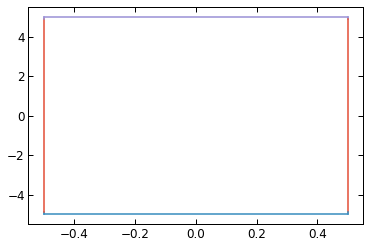

In [11]:
frame.gen_fig();